In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import pandas as pd
import pickle as pkl
from sklearn import decomposition
from config import config_dict as c
import pymysql
import pymysql.cursors

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def call_db(sql):

    connecting = pymysql.connect(host=c['host'], port=c['port'],
                                 user=c['user'], passwd=c['passwd'],
                                 db=c['db'], charset='utf8')
    curs = connecting.cursor(pymysql.cursors.DictCursor)
    curs.execute(sql)
    rows = curs.fetchall()
    df = pd.DataFrame(data=rows)

    return df

In [3]:
person = call_db('select GYEAR, PCODE, NAME, TEAM, POS, POSITION, HITTYPE, MONEY from person where GYEAR < 2019')

In [4]:
with open('./model/weight.pkl', 'rb') as f:
    weight = pkl.load(f)
    
with open('./pkl/hitter_info.pkl', 'rb') as f:
    hitter_info = pkl.load(f)

with open('./pkl/pitcher_info.pkl', 'rb') as f:
    pitcher_info = pkl.load(f)

In [5]:
batter_vec = weight['hitter_layer.0.weight'].cpu()
pitcher_vec = weight['pitcher_layer.0.weight'].cpu()
player_vecs = {"batter": batter_vec, "pitcher": pitcher_vec}

In [6]:
type_dict = {'우투우타':'R', '우투좌타':"L", "좌투좌타":"L", "우언우타":"R", "좌투우타":"R",
            "우투양타":"B", "우언좌타":"L", "우언양타":"B"}

In [7]:
from sklearn import decomposition

pca = decomposition.PCA()
pca.fit(batter_vec.tolist())
print(pca.explained_variance_ratio_)
projected_batters = pca.transform(batter_vec.tolist())

pca = decomposition.PCA()
pca.fit(pitcher_vec.tolist())
print(pca.explained_variance_ratio_)
projected_pitchers = pca.transform(pitcher_vec.tolist())

[0.27444816 0.21840864 0.13223446 0.08757556 0.07161641 0.06675298
 0.05583808 0.04850953 0.04461617]
[0.26063393 0.16280812 0.13816327 0.1125875  0.09052697 0.0779411
 0.06046233 0.05328449 0.04359229]


In [8]:
hittype_ls = []
for i in hitter_info.HITPCODE:
    hittype_ls.append(person[person.PCODE == i].HITTYPE.unique()[0])
hitter_info['HITTYPE'] = hittype_ls

hittype_ls2 = []
for i in pitcher_info.PITPCODE:
    hittype_ls2.append(person[person.PCODE == i].HITTYPE.unique()[0])
pitcher_info['HITTYPE'] = hittype_ls2

In [9]:
categories = {'batter': hitter_info.HITNAME.values.tolist(), 'pitcher':pitcher_info.PITNAME.values.tolist()}

In [10]:
batter_colors = {"player_id": [], "hand": []}
for i in range(len(hitter_info)):
    batter_id = categories["batter"][i]
    batting_hand = hitter_info.HITTYPE[i]
    salary = hitter_info.SALARY[i]
    batter_colors["player_id"].append(batter_id)
    batter_colors["hand"].append(batting_hand)

df = pd.DataFrame(batter_colors)

In [11]:
df.hand.value_counts()

우투우타    329
좌투좌타    106
우투좌타     45
우투양타      8
Name: hand, dtype: int64

In [12]:
for i in range(3):
    df["pc{0}".format(i + 1)] = projected_batters[:, i]

In [13]:
tmp = []
for i in range(len(df)):
    tmp.append(type_dict[df.hand[i]])

In [14]:
df['HITTYPE_ENG'] = tmp

In [15]:
df.HITTYPE_ENG.value_counts()

R    329
L    151
B      8
Name: HITTYPE_ENG, dtype: int64

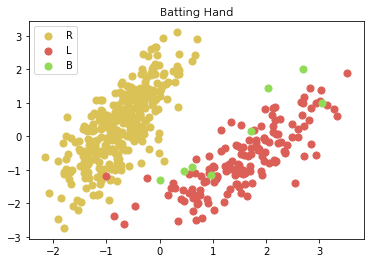

In [16]:
cmap = sns.cubehelix_palette(as_cmap = True)
cs = sns.color_palette("hls", 8)
batting_hand_color = {"R": cs[1], "L": cs[0], "B": cs[2]}
legend_data = []
legend_names = []
for (hand, color) in batting_hand_color.items():
    batter_hands = df[df.HITTYPE_ENG == hand]
    legend_data.append(plt.scatter(batter_hands["pc1"], batter_hands["pc2"], s = 50, color = color))
    legend_names.append(hand)

plt.title("Batting Hand", fontproperties=fontprop)
plt.legend(legend_data, legend_names)
plt.show()